## Import

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import ElectraTokenizer, ElectraForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
import matplotlib.pyplot as plt
from googletrans import Translator

## Data Load

In [25]:
# ✅ 학습 장치 설정: CUDA, MPS, CPU 자동 선택
device = (
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cpu")
)
print(f"Using device: {device}")

# ✅ 데이터 로드
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

Using device: cuda


## 데이터 전처리

### Data Augmentation

In [26]:
# ✅ 텍스트 컬럼 강제 변환 (float 방지)
train_df["text"] = train_df["text"].fillna("").astype(str)
test_df["text"] = test_df["text"].fillna("").astype(str)

# ✅ Back Translation (Google 번역 API 활용)
translator = Translator()

def back_translate(text):
    """Google 번역 API를 이용한 Back Translation (한글 → 영어 → 한글)"""
    try:
        english_text = translator.translate(text, src="ko", dest="en").text
        translated_text = translator.translate(english_text, src="en", dest="ko").text
        return translated_text
    except:
        return text  # 번역 실패 시 원문 반환

# ✅ Noise Injection (랜덤 문자 추가)
def inject_noise(text, noise_ratio=0.1):
    """문장에 랜덤하게 오타(문자 변경)를 삽입하는 함수"""
    if not isinstance(text, str):  # 문자열이 아닐 경우 변환
        text = str(text)
    
    text = list(text)
    num_noises = int(len(text) * noise_ratio)
    for _ in range(num_noises):
        idx = random.randint(0, len(text) - 1)
        text[idx] = random.choice("abcdefghijklmnopqrstuvwxyz")  # 랜덤 문자 삽입
    return "".join(text)

# ✅ 데이터 증강 적용 (5% 샘플에 적용)
augmented_texts = []
augmented_labels = []

for _, row in train_df.sample(frac=0.05, random_state=42).iterrows():
    original_text = row["text"]
    label = row["class"]

    # Back Translation
    back_translated_text = back_translate(original_text)
    augmented_texts.append(back_translated_text)
    augmented_labels.append(label)

    # Noise Injection
    noisy_text = inject_noise(original_text)
    augmented_texts.append(noisy_text)
    augmented_labels.append(label)

# ✅ 증강 데이터 추가
aug_df = pd.DataFrame({"text": augmented_texts, "class": augmented_labels})
train_df = pd.concat([train_df, aug_df], ignore_index=True)

# ✅ 변환 완료된 데이터 확인
print(f"🔹 데이터 증강 완료: 총 {len(train_df)}개 샘플")
print(train_df.head())

🔹 데이터 증강 완료: 총 10890개 샘플
   idx  class                                               text
0  0.0      0  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1  1.0      0  길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2  2.0      3  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3  3.0      1  어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4  4.0      1  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


## Dataset 클래스 정의

In [46]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128, is_test=False):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        text = self.dataframe.iloc[index]["text"]
        inputs = self.tokenizer(
            text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt"
        )
        
        # 테스트 데이터셋인 경우, "class" 컬럼이 있으면 라벨 포함, 없으면 입력만 반환
        if self.is_test:
            if "class" in self.dataframe.columns:
                label = int(self.dataframe.iloc[index]["class"])
                return {
                    "input_ids": inputs["input_ids"].squeeze(0),
                    "attention_mask": inputs["attention_mask"].squeeze(0),
                    "label": torch.tensor(label, dtype=torch.long),
                }
            else:
                return {
                    "input_ids": inputs["input_ids"].squeeze(0),
                    "attention_mask": inputs["attention_mask"].squeeze(0),
                }
        
        # 학습/검증용 데이터셋은 반드시 라벨이 존재해야 함
        label = int(self.dataframe.iloc[index]["class"])
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }


## 모델 및 데이터 준비

In [47]:
# ✅ 모델 및 토크나이저 설정
MODEL_NAME = "monologg/koelectra-base-v3-discriminator"
tokenizer = ElectraTokenizer.from_pretrained(MODEL_NAME)
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(train_df["class"].unique()))
model.to(device)

# ✅ Train-Test 데이터 분할
train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["class"])
train_dataset = TextDataset(train_data, tokenizer)
valid_dataset = TextDataset(valid_data, tokenizer)
test_dataset = TextDataset(test_df, tokenizer, is_test=True)

# ✅ 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 학습 루프 및 손실값 시각화

In [53]:
import torch
import torch.nn as nn
from transformers import AdamW
from sklearn.metrics import f1_score

# ✅ 옵티마이저 및 손실 함수 정의
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)  # AdamW 옵티마이저
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss (다중 분류)

# ✅ 학습 파라미터 설정 및 기록 변수 초기화
EPOCHS = 15
train_losses, valid_losses, test_losses = [], [], []
train_f1_scores, valid_f1_scores, test_f1_scores = [], [], []

best_test_f1 = 0.0  # 테스트 F1 기준 베스트 모델 저장을 위한 변수

for epoch in range(EPOCHS):
    # ----- 학습 단계 -----
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
    
    train_f1 = f1_score(all_labels, all_preds, average="macro")
    train_losses.append(total_loss)
    train_f1_scores.append(train_f1)
    
    # ----- 검증 단계 -----
    model.eval()
    valid_loss = 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            valid_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    valid_f1 = f1_score(all_labels, all_preds, average="macro")
    valid_losses.append(valid_loss)
    valid_f1_scores.append(valid_f1)
    
    # ----- 테스트 평가 단계 -----
    test_loss = 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            test_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    test_f1 = f1_score(all_labels, all_preds, average="macro")
    test_losses.append(test_loss)
    test_f1_scores.append(test_f1)
    
    # 베스트 테스트 F1 기준 모델 저장
    if test_f1 > best_test_f1:
        best_test_f1 = test_f1
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Epoch {epoch+1}: New best model saved with Test F1: {test_f1:.4f}")
    
    # ----- 결과 출력 (한 줄에 모두 출력) -----
    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Train F1: {train_f1:.4f} | "
          f"Valid Loss: {valid_loss:.4f} | Valid F1: {valid_f1:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test F1: {test_f1:.4f}")


c:\Users\minho\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: New best model saved with Test F1: 0.8790
Epoch 1 | Train Loss: 22.1304 | Train F1: 0.9891 | Valid Loss: 42.2153 | Valid F1: 0.9257 | Test Loss: 39.0750 | Test F1: 0.8790
Epoch 2 | Train Loss: 20.6035 | Train F1: 0.9891 | Valid Loss: 47.3502 | Valid F1: 0.9169 | Test Loss: 45.9111 | Test F1: 0.8658
Epoch 3 | Train Loss: 15.4424 | Train F1: 0.9924 | Valid Loss: 49.3713 | Valid F1: 0.9182 | Test Loss: 45.3158 | Test F1: 0.8660
Epoch 4 | Train Loss: 12.5175 | Train F1: 0.9935 | Valid Loss: 48.5466 | Valid F1: 0.9192 | Test Loss: 43.6270 | Test F1: 0.8702
Epoch 5 | Train Loss: 12.0489 | Train F1: 0.9931 | Valid Loss: 48.2009 | Valid F1: 0.9217 | Test Loss: 41.8760 | Test F1: 0.8720
Epoch 6: New best model saved with Test F1: 0.8852
Epoch 6 | Train Loss: 9.5463 | Train F1: 0.9945 | Valid Loss: 43.2394 | Valid F1: 0.9313 | Test Loss: 43.2788 | Test F1: 0.8852
Epoch 7 | Train Loss: 8.4747 | Train F1: 0.9950 | Valid Loss: 44.6172 | Valid F1: 0.9297 | Test Loss: 40.5716 | Test F1: 0.88

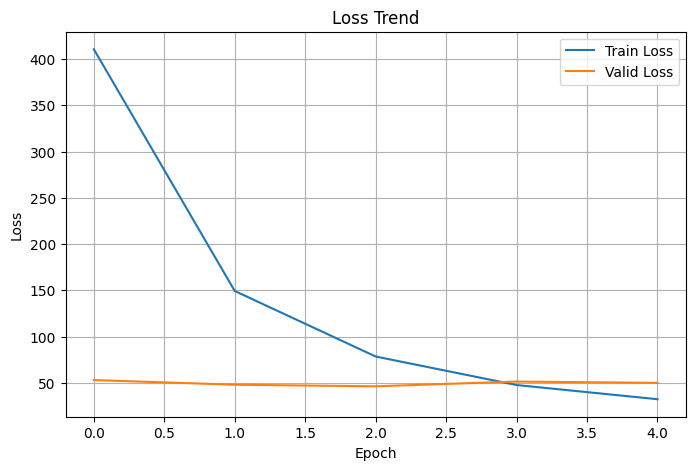

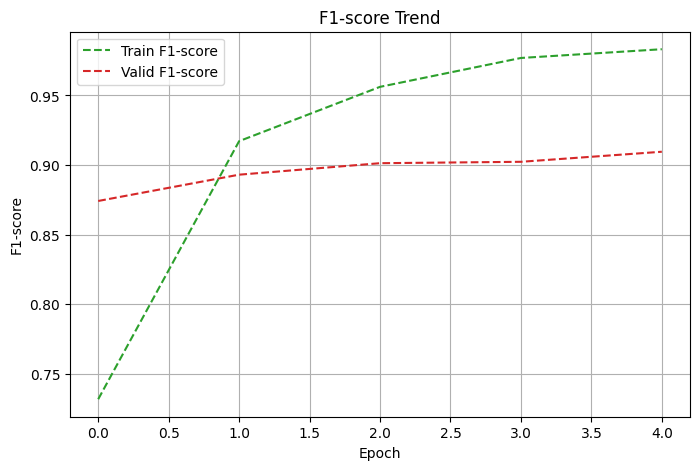

In [49]:
# ✅ 학습 과정 시각화 (Loss & F1-score)

# ✅ Loss 그래프
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", color="tab:blue")
plt.plot(valid_losses, label="Valid Loss", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Trend")
plt.legend()
plt.grid()
plt.show()

# ✅ F1-score 그래프
plt.figure(figsize=(8, 5))
plt.plot(train_f1_scores, label="Train F1-score", color="tab:green", linestyle="--")
plt.plot(valid_f1_scores, label="Valid F1-score", color="tab:red", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("F1-score Trend")
plt.legend()
plt.grid()
plt.show()

## submission

In [54]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader

# ✅ GPU 또는 CPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 베스트 모델 로드 (저장한 모델 파일 경로가 "best_model.pth"라고 가정)
best_model_path = "best_model.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

# ✅ 테스트 데이터셋에 대한 DataLoader 생성 (batch_size는 메모리 상황에 맞게 조정)
test_loader = DataLoader(test_dataset, batch_size=8)

# ✅ 예측값을 저장할 리스트
all_preds = []

# ✅ 예측 수행
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)

# ✅ idx 형식을 "t_000", "t_001", ... 으로 변환 (3자리 숫자 포맷팅)
idx_list = [f"t_{i:03d}" for i in range(len(all_preds))]

# ✅ 예측 결과 저장
if len(idx_list) == len(all_preds):  # 데이터 개수가 일치하는지 확인
    submission = pd.DataFrame({
        "idx": idx_list,      # 변환된 인덱스
        "target": all_preds   # 예측된 클래스 값
    })

    # 현재 작업 디렉토리에 submission.csv 파일로 저장
    current_dir = os.getcwd()
    submission_path = os.path.join(current_dir, "submission.csv")
    submission.to_csv(submission_path, index=False)

    print(f"✅ 예측 결과 저장 완료! 결과 파일: {submission_path}")
else:
    print(f"⚠️ 오류: idx_list({len(idx_list)})와 all_preds({len(all_preds)}) 크기가 맞지 않습니다.")



✅ 예측 결과 저장 완료! 결과 파일: c:\Users\minho\DLthon\submission.csv


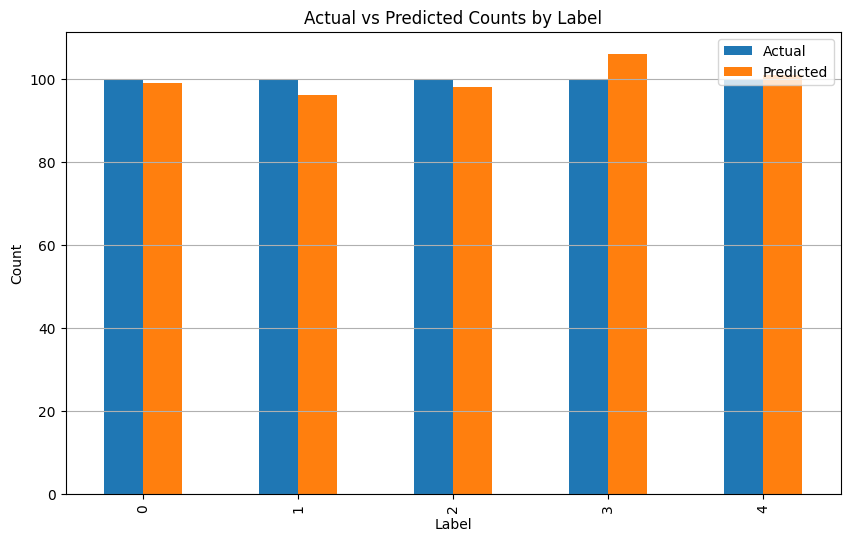

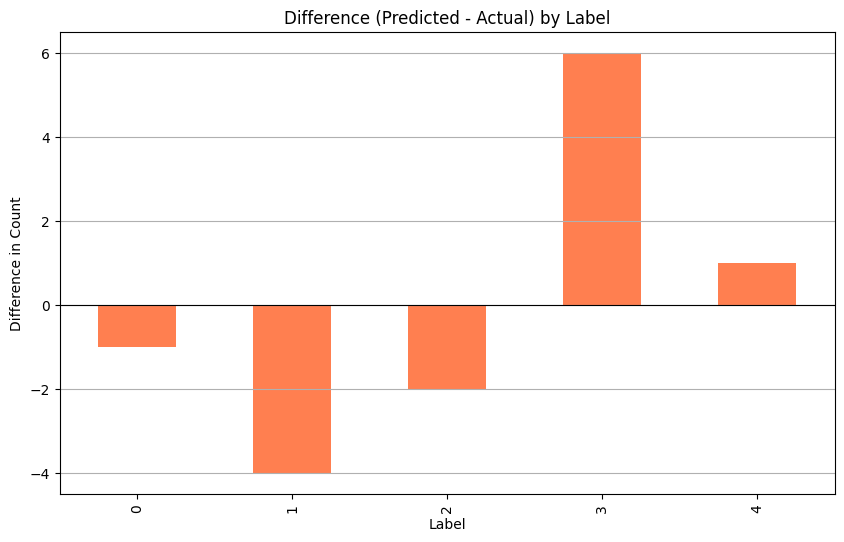

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# 📌 CSV 파일 불러오기
submission = pd.read_csv("submission.csv")
test_data = pd.read_csv("test.csv")

# 📌 컬럼명 정리
submission = submission.rename(columns={"target": "predicted"})  # 예측 값
test_data = test_data.rename(columns={"class": "actual"})         # 실제 정답 값

# 📌 'idx' 기준으로 병합
merged = pd.merge(submission, test_data[["idx", "actual"]], on="idx", how="inner")

# 📌 실제 값과 예측 값 추출
y_true = merged["actual"]
y_pred = merged["predicted"]

# 📌 각 레이블별 실제 개수와 예측 개수 집계
actual_counts = y_true.value_counts().sort_index()
pred_counts = y_pred.value_counts().sort_index()

# 두 시리즈를 하나의 데이터프레임으로 병합 (인덱스: 레이블)
df_counts = pd.DataFrame({
    "Actual": actual_counts,
    "Predicted": pred_counts
}).fillna(0)  # 누락된 값은 0으로 채움

# 레이블별 차이 계산 (예측 - 실제)
df_counts["Difference"] = df_counts["Predicted"] - df_counts["Actual"]

# 📌 Actual vs Predicted 시각화 (막대그래프)
plt.figure(figsize=(10, 6))
df_counts[['Actual', 'Predicted']].plot(kind='bar', ax=plt.gca())
plt.title("Actual vs Predicted Counts by Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y')
plt.legend(loc='upper right')
plt.show()

# 📌 예측과 실제의 차이를 시각화 (차이 막대그래프)
plt.figure(figsize=(10, 6))
df_counts["Difference"].plot(kind='bar', color='coral')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Difference (Predicted - Actual) by Label")
plt.xlabel("Label")
plt.ylabel("Difference in Count")
plt.grid(axis='y')
plt.show()